In [1]:
import numpy as np
import pandas as pd

# 경고 무시
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='geopandas')

import geopandas as gpd
from shapely.geometry import Point

# 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder

# 스케일러
from sklearn.preprocessing import MinMaxScaler

# 거리계산
from scipy.spatial.distance import cdist
from haversine import haversine, Unit
from sklearn.metrics.pairwise import haversine_distances

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
pd.set_option('mode.chained_assignment',  None)

In [3]:
df1= pd.read_csv('../data/1-12.공공주택임대_정보(화성시).csv')
df2= pd.read_csv('../data/1-13.공공주택임대_임대료(화성시).csv')
df3= pd.read_csv('../data/1-1.화성시_거주인구.csv')
df4= pd.read_csv('../data/1-11.화성시_공유차량_이용현황.csv')
df5 = gpd.read_file('../data/1-14.화성시_격자.geojson')
df6 = pd.read_csv('../data/화성인구+블록코드_all.csv')
df7 = pd.read_csv('../data/1-6.화성시_지하철역.csv')

df_공공주택임대정보 = df1.copy()
df_공공주택임대료 = df2.copy()
df_거주인구 = df3.copy()
df_공유차량 = df4.copy()
df_map = df5.copy()
df_화성인구 = df6.copy()
df_지하철역 = df7.copy()

# 격자 정보 추가
df_거주인구 = df_map.merge(df_거주인구, on='gid')

## column명 변경

In [4]:
df_공공주택임대정보.columns=['단지코드','단지명','지원유형','세대수','주차면수','경도','위도']
df_공공주택임대료.columns=['단지코드','단지명','지원유형','단지평수','월세','경도','위도']
df_공유차량.columns=['단지명', '단지코드', '이용건수_2008', '이용시간_2008', '이용건수_2009', '이용시간_2009', 
               '이용건수_2010', '이용시간_2010', '이용건수_2011', '이용시간_2011', '이용건수_2012', '이용시간_2012',
               '이용건수_2101', '이용시간_2101', '이용건수_2102', '이용시간_2102', '이용건수_2103', '이용시간_2103',
               '이용건수_2104', '이용시간_2104', '이용건수_2105', '이용시간_2105', '이용건수_2106', '이용시간_2106',
               '이용건수_2107', '이용시간_2107', '이용건수_2108', '이용시간_2108', '이용건수_2109', '이용시간_2109',
               '이용건수_2110', '이용시간_2110', '이용건수_2111', '이용시간_2111', '이용건수_2112', '이용시간_2112',
               '이용건수_2201', '이용시간_2201', '이용건수_2202', '이용시간_2202', '이용건수_2203', '이용시간_2203',
               '이용건수_2204', '이용시간_2204', '이용건수_2205', '이용시간_2205', '이용건수_2206', '이용시간_2206',
               '이용건수_2207', '이용시간_2207', '이용건수_2208', '이용시간_2208', '이용건수_2209', '이용시간_2209',
               '이용건수_2210', '이용시간_2210', '이용건수_2211', '이용시간_2211', '이용건수_2212', '이용시간_2212',
               '이용건수_2301', '이용시간_2301', '이용건수_2302', '이용시간_2302', '이용건수_2303', '이용시간_2303',
               '이용건수_2304', '이용시간_2304', '이용건수_2305', '이용시간_2305', '이용건수_2306', '이용시간_2306',
               '이용건수_2307', '이용시간_2307', '이용건수_2308', '이용시간_2308', '이용건수_2309', '이용시간_2309',
               '이용건수_2310', '이용시간_2310', '이용건수_2311', '이용시간_2311', '이용건수_2312', '이용시간_2312',
               '전체이용건수', '전체이용시간', '차량유형', '설치대수']
df_지하철역.columns = ['지하철역','노선','경도','위도']

## 거주인구 데이터 중 LH공공주택만 추출

In [5]:
# 거주인구와 화성인구(LH 공급주택 정보)를 merge
df_거주인구 = pd.merge(df_거주인구, df_화성인구, on=['gid', 'm_20g_pop', 'w_20g_pop', 'm_30g_pop',
       'w_30g_pop', 'm_40g_pop', 'w_40g_pop', 'm_50g_pop', 'w_50g_pop',
       'm_60g_pop', 'w_60g_pop', 'm_70g_pop', 'w_70g_pop', 'm_80g_pop',
       'w_80g_pop', 'm_90g_pop', 'w_90g_pop', 'm_100g_pop', 'w_100g_pop'], how='outer')
df_거주인구.rename(columns={'blck_cd': '단지코드'}, inplace=True)
df_거주인구.rename(columns={'year_x': 'year'}, inplace=True)
df_거주인구.drop(['year_y'],axis=1,inplace=True)
df_거주인구['단지코드'] = df_거주인구.groupby('gid')['단지코드'].transform('first')

# LH 공급주택만 추출
df_거주인구 = df_거주인구[df_거주인구['단지코드'].notna()]   
df_거주인구 = df_거주인구.reset_index(drop=True)

# total_pop과 youth_pop 재계산
df_거주인구.total_pop = df_거주인구[['m_20g_pop', 'w_20g_pop', 'm_30g_pop',
       'w_30g_pop', 'm_40g_pop', 'w_40g_pop', 'm_50g_pop', 'w_50g_pop',
       'm_60g_pop', 'w_60g_pop', 'm_70g_pop', 'w_70g_pop', 'm_80g_pop',
       'w_80g_pop', 'm_90g_pop', 'w_90g_pop', 'm_100g_pop', 'w_100g_pop']].sum(axis=1)
df_거주인구.youtu_pop = df_거주인구[['m_20g_pop', 'w_20g_pop', 'm_30g_pop','w_30g_pop']].sum(axis=1)

####  거주인구와 공공주택단지를 merge

단지코드가 없어 누락된 행에 대해  
QGIS 사진을 근거로 gid를 다사469016으로 대체하고 연도를 2020,2021,2022,2023로 행 추가 

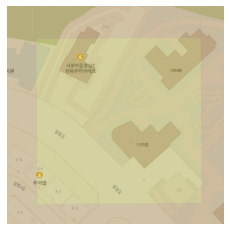

In [6]:
# 격자사진 출력
image_path = "../data/C02361격자_다사469016.png"
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.axis("off")
plt.show()

In [7]:
# 공공주택단지와 거주인구 merge
df_거주인구_sub = pd.merge(df_공공주택임대정보, df_거주인구, on='단지코드', how='outer')
print(df_거주인구_sub[df_거주인구_sub.year.isna()])  # 누락된 행 확인

# 누락된 행에 대해 QGIS 사진 정보를 토대로 행 생성
df_거주인구_sub.loc[df_거주인구_sub.단지코드 == 'C02361', 'gid'] = '다사469016'
base_row = df_거주인구_sub.loc[df_거주인구_sub.단지코드 == 'C02361'].iloc[0].to_dict()
new_rows = []
for year in [2020, 2021, 2022, 2023]:
    new_row = base_row.copy()
    new_row['year'] = year
    new_rows.append(new_row)

# 누락된 행 추가
df_거주인구_sub = pd.concat([df_거주인구_sub, pd.DataFrame(new_rows)], ignore_index=True)
df_거주인구_sub = df_거주인구_sub[~((df_거주인구_sub.단지코드 == 'C02361') & (df_거주인구_sub.year.isna()))]  # NAN인 행 삭제
df_거주인구_sub=df_거주인구_sub.reset_index(drop=True)
df_거주인구_sub[df_거주인구_sub.단지코드 == 'C02361'].year.unique()

        단지코드                   단지명  지원유형  세대수   주차면수          경도         위도  \
1120  C02361  화성향남2(20단지)(행복,임대상가)  행복주택   99  148.5  126.902624  37.112353   

      gid geometry  year  ...  m_80g_pop  w_80g_pop  m_90g_pop  w_90g_pop  \
1120  NaN     None   NaN  ...        NaN        NaN        NaN        NaN   

      m_100g_pop  w_100g_pop  total_pop  youth_pop  23_20_tota  23_20_yout  
1120         NaN         NaN        NaN        NaN         NaN         NaN  

[1 rows x 32 columns]


array([2020., 2021., 2022., 2023.])

## 거주인구 결측치 대체
- 23년 결측치가 적으므로 22년 결측치에 대해 우선적으로 23년 행의 데이터로 대체
- 잔여 결측치에 대해서는 fiina(0)과 코사인 유사도 기반 결측치 대체 시행

In [8]:
df_거주인구_sub_2022 = df_거주인구_sub[df_거주인구_sub.year == 2022].reset_index(drop=True)
df_거주인구_sub_2023 = df_거주인구_sub[df_거주인구_sub.year == 2023].reset_index(drop=True)
print(df_거주인구_sub_2023.isna().sum())   # 23년 결측치
print('-------------------------------------------')
print(df_거주인구_sub_2022.isna().sum())   # 22년 결측치

단지코드            0
단지명             0
지원유형            0
세대수             0
주차면수            0
경도              0
위도              0
gid             0
geometry        1
year            0
m_20g_pop      64
w_20g_pop      67
m_30g_pop      63
w_30g_pop      66
m_40g_pop      66
w_40g_pop      64
m_50g_pop      75
w_50g_pop      80
m_60g_pop      78
w_60g_pop      71
m_70g_pop      95
w_70g_pop      90
m_80g_pop     147
w_80g_pop     111
m_90g_pop     356
w_90g_pop     250
m_100g_pop    437
w_100g_pop    433
total_pop       1
youth_pop       1
23_20_tota      1
23_20_yout      1
dtype: int64
-------------------------------------------
단지코드            0
단지명             0
지원유형            0
세대수             0
주차면수            0
경도              0
위도              0
gid             0
geometry        1
year            0
m_20g_pop     165
w_20g_pop     167
m_30g_pop     165
w_30g_pop     167
m_40g_pop     165
w_40g_pop     166
m_50g_pop     171
w_50g_pop     173
m_60g_pop     165
w_60g_pop     169
m_70g_p

### 23년 데이터로 22년 결측치 대체

In [9]:
# 23년도 거주인구 데이터 추출
df_2023_subset = df_거주인구_sub_2023[['단지코드', 'm_20g_pop', 'w_20g_pop', 'm_30g_pop', 'w_30g_pop',
                          'm_40g_pop', 'w_40g_pop', 'm_50g_pop', 'w_50g_pop',
                          'm_60g_pop', 'w_60g_pop', 'm_70g_pop', 'w_70g_pop',
                          'm_80g_pop', 'w_80g_pop', 'm_90g_pop', 'w_90g_pop',
                          'm_100g_pop', 'w_100g_pop', 'total_pop', 'youth_pop']]

# 2022 결측치 대체( 23년 데이터 기반)
# 2022년 값이 NaN인 경우 2023년 값으로 대체

df_2022_filled = pd.concat([df_거주인구_sub_2022, df_2023_subset.add_suffix('_2023')], axis=1)
for col in ['m_20g_pop', 'w_20g_pop', 'm_30g_pop', 'w_30g_pop',
            'm_40g_pop', 'w_40g_pop', 'm_50g_pop', 'w_50g_pop',
            'm_60g_pop', 'w_60g_pop', 'm_70g_pop', 'w_70g_pop',
            'm_80g_pop', 'w_80g_pop', 'm_90g_pop', 'w_90g_pop',
            'm_100g_pop', 'w_100g_pop', 'total_pop', 'youth_pop']:
    df_2022_filled[col] = df_2022_filled[col].fillna(df_2022_filled[f"{col}_2023"])

# 2023년 열 제거
columns_to_drop = [f"{col}_2023" for col in df_2023_subset.columns if col != '단지코드']
df_2022_filled.drop(columns=columns_to_drop, inplace=True)

# 22년 데이터 갱신
df_거주인구_sub_2022 = df_2022_filled

# 결측치 확인
print(df_2022_filled.isna().sum())

단지코드            0
단지명             0
지원유형            0
세대수             0
주차면수            0
경도              0
위도              0
gid             0
geometry        1
year            0
m_20g_pop      59
w_20g_pop      63
m_30g_pop      59
w_30g_pop      62
m_40g_pop      62
w_40g_pop      60
m_50g_pop      69
w_50g_pop      75
m_60g_pop      71
w_60g_pop      66
m_70g_pop      89
w_70g_pop      85
m_80g_pop     136
w_80g_pop      97
m_90g_pop     333
w_90g_pop     230
m_100g_pop    435
w_100g_pop    431
total_pop       1
youth_pop       1
23_20_tota    387
23_20_yout    387
단지코드_2023       0
dtype: int64


In [10]:
# 단지코드를 기준으로 중복되는 행 제거

 # Sum을 하는 과정에서 NaN이 하나라도 포함되어 있으면 NaN 반환
def safe_sum(series):
    if series.isna().any():
        return np.nan
    return series.sum()

# 중복 제거
df_거주인구_sub_2022_2 = df_거주인구_sub_2022.groupby(['단지코드', '단지명', '지원유형', '세대수', '경도', '위도']).agg( 
    gid=('gid', lambda x: list(x)),  # gid를 리스트로 묶음
    m_20g_pop=('m_20g_pop', safe_sum),
    w_20g_pop=('w_20g_pop', safe_sum),
    m_30g_pop=('m_30g_pop', safe_sum),
    w_30g_pop=('w_30g_pop', safe_sum),
    m_40g_pop=('m_40g_pop', safe_sum),
    w_40g_pop=('w_40g_pop', safe_sum),
    m_50g_pop=('m_50g_pop', safe_sum),
    w_50g_pop=('w_50g_pop', safe_sum),
    m_60g_pop=('m_60g_pop', safe_sum),
    w_60g_pop=('w_60g_pop', safe_sum),
    m_70g_pop=('m_70g_pop', safe_sum),
    w_70g_pop=('w_70g_pop', safe_sum),
    m_80g_pop=('m_80g_pop', safe_sum),
    w_80g_pop=('w_80g_pop', safe_sum),
    m_90g_pop=('m_90g_pop', safe_sum),
    w_90g_pop=('w_90g_pop', safe_sum),
    m_100g_pop=('m_100g_pop', safe_sum),
    w_100g_pop=('w_100g_pop', safe_sum),
    total_pop=('total_pop', safe_sum),
    youth_pop=('youth_pop', safe_sum)
).reset_index()

In [11]:
df_거주인구_sub_2022_2.isna().sum() # 잔여 결측치

단지코드           0
단지명            0
지원유형           0
세대수            0
경도             0
위도             0
gid            0
m_20g_pop     27
w_20g_pop     28
m_30g_pop     28
w_30g_pop     28
m_40g_pop     29
w_40g_pop     29
m_50g_pop     32
w_50g_pop     35
m_60g_pop     34
w_60g_pop     33
m_70g_pop     39
w_70g_pop     39
m_80g_pop     56
w_80g_pop     44
m_90g_pop     78
w_90g_pop     72
m_100g_pop    79
w_100g_pop    79
total_pop      1
youth_pop      1
dtype: int64

### fillna(0)과 코사인 유사도 기반 잔여 결측치 대체

###### 80~100 대 결측치 처리
- 0으로 대체 (fillna)

In [12]:
df_거주인구_sub_2022_2[['m_80g_pop', 'w_80g_pop', 'm_90g_pop', 'w_90g_pop', 'm_100g_pop', 'w_100g_pop']] = df_거주인구_sub_2022_2[['m_80g_pop', 'w_80g_pop', 'm_90g_pop', 'w_90g_pop', 'm_100g_pop', 'w_100g_pop']].fillna(0)

In [13]:
df_거주인구_sub_2022_2.total_pop = df_거주인구_sub_2022_2[['m_20g_pop', 'w_20g_pop', 'm_30g_pop',
       'w_30g_pop', 'm_40g_pop', 'w_40g_pop', 'm_50g_pop', 'w_50g_pop',
       'm_60g_pop', 'w_60g_pop', 'm_70g_pop', 'w_70g_pop', 'm_80g_pop',
       'w_80g_pop', 'm_90g_pop', 'w_90g_pop', 'm_100g_pop', 'w_100g_pop']].sum(axis=1)
df_거주인구_sub_2022_2.youth_pop = df_거주인구_sub_2022_2[['m_20g_pop', 'w_20g_pop', 'm_30g_pop','w_30g_pop']].sum(axis=1)

#### 코사인 유사도 기반으로 결측치 대체  
→ 20~70대에 대해 순차적으로 코사인 유사도 계산 후 대체

- 코사인 유사도 계산 과정에 역세권 정보 반영  
→ 아파트와 지하철 역 간 거리 계산

In [14]:
# haversine 공식을 토대로 거리 계산
def calculate_haversine(row, subway_data):
    apartment = (row['위도'], row['경도'])
    distances = subway_data.apply(
        lambda r: haversine(apartment, (r['위도'], r['경도']), unit=Unit.KILOMETERS),
        axis=1
    )
    return distances

# 가장 가까운 지하철 역, 거리 계산
df_거주인구_sub_2022_2['가장가까운지하철역까지거리'] = df_거주인구_sub_2022_2.apply(
    lambda row: calculate_haversine(row, df_지하철역).min(),
    axis=1
)
df_거주인구_sub_2022_2['가장가까운지하철역'] = df_거주인구_sub_2022_2.apply(
    lambda row: df_지하철역.iloc[calculate_haversine(row, df_지하철역).idxmin()]['지하철역'],
    axis=1
)

##### 코사인 유사도 계산

In [15]:
# 연령별 컬럼 리스트 (연령별 거주인구 열)
age_columns = [
    'm_20g_pop', 'w_20g_pop', 'm_30g_pop', 'w_30g_pop', 
    'm_40g_pop', 'w_40g_pop', 'm_50g_pop', 'w_50g_pop',
    'm_60g_pop', 'w_60g_pop', 'm_70g_pop', 'w_70g_pop',
    'm_80g_pop', 'w_80g_pop', 'm_90g_pop', 'w_90g_pop',
    'm_100g_pop', 'w_100g_pop'
]

# 1. '지원유형'을 원-핫 인코딩
encoder = OneHotEncoder()
encoded_columns = encoder.fit_transform(df_거주인구_sub_2022_2[['지원유형']]).toarray()

# 원-핫 인코딩 결과를 새로운 DataFrame에 저장
encoded_feature_names = [f'지원유형_{category}' for category in encoder.categories_[0]]
encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names)

# 원-핫 인코딩 결과와 '가장 가까운 지하철역까지 거리'를 포함한 DataFrame 생성
combined_df = pd.concat([encoded_df, df_거주인구_sub_2022_2[['가장가까운지하철역까지거리']].reset_index(drop=True)], axis=1)

# 2. 코사인 유사도 계산
cosine_sim = cosine_similarity(combined_df)

###### 20대 결측치 처리

In [16]:
# 1. m,w_20g_pop이 NaN인 행의 인덱스 추출
missing_indices = df_거주인구_sub_2022_2[df_거주인구_sub_2022_2.m_20g_pop.isna() | df_거주인구_sub_2022_2.w_20g_pop.isna()].index

# 2. 코사인 유사도 계산을 위해 결측치를 0으로 채워 임시 데이터 생성 (유사도 계산용)
similarity_data = df_거주인구_sub_2022_2[age_columns].fillna(0).values
cosine_sim = cosine_similarity(similarity_data, similarity_data)

# 3. 결측치를 각 행별로 대체
for target_index in missing_indices:
    # 유사도 계산 및 유효한 상위 행 찾기
    similarities = list(enumerate(cosine_sim[target_index]))
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # 유사도 순위대로 처리
    for sim_index, (row_index, sim_value) in enumerate(sorted_similarities[1:], start=1):  # 자기 자신 제외
        # 유효한 행인지 확인 (해당 행에 결측치가 없는지)
        if not df_거주인구_sub_2022_2.iloc[row_index][age_columns].isna().any():
            # 가장 유사한 행을 가져옴
            top_row = df_거주인구_sub_2022_2.iloc[row_index]

            # 기준 행 데이터
            target_row = df_거주인구_sub_2022_2.iloc[target_index]

            # 유사한 행의 연령별 비율 계산
            total_pop = top_row[age_columns].sum()
            if total_pop > 0:  # 유효한 총합인 경우
                top_ratios = {col: top_row[col] / total_pop for col in age_columns}
            else:
                top_ratios = {col: 0 for col in age_columns}

            # 결측치 대체
            for col in age_columns:
                if pd.isnull(target_row[col]):  # 결측치인 경우만 대체
                    df_거주인구_sub_2022_2.loc[target_index, col] = (
                        df_거주인구_sub_2022_2.loc[target_index, '세대수'] * top_ratios.get(col, 0)
                    )
            break  # 대체가 완료되었으므로 루프 종료

# 4. 결과 확인 (결측치가 대체된 데이터)
print(df_거주인구_sub_2022_2.loc[missing_indices])

      단지코드                               단지명  지원유형   세대수          경도  \
0   C00414                            화성태안12  국민임대  1178  127.041121   
20  C01873           화성동탄2 A24블럭(4단지)(국임/영구)  국민임대  1547  127.121597   
21  C01873           화성동탄2 A24블럭(4단지)(국임/영구)  영구임대   600  127.121597   
26  C02014    (NHF제3호)화성동탄2 A50블럭(22단지 르파비스)  공공임대   876  127.126406   
35  C02194               화성동탄2 A6블럭(1단지)(국민)  국민임대   730  127.115160   
36  C02195               화성동탄2 A6블럭(1단지)(영구)  영구임대   216  127.114400   
38  C02248    (NHF제11호)화성동탄2 A89블럭(29단지 아이원)  공공임대   448  127.103992   
42  C02329  (NHF제12호)화성동탄2 A63블럭(23단지 센트럴써밋)  공공임대   740  127.123518   
43  C02330   (NHF제13호)화성동탄2 A81블럭(36단지 하우스디)  공공임대   872  127.126506   
45  C02347          화성남양뉴타운(LH10단지)(국임,임대상가)  국민임대  1022  126.834651   
46  C02358        (NHF제15호)화성남양뉴타운(1단지 루나포레)  공공임대   486  126.831201   
48  C02361              화성향남2(20단지)(행복,임대상가)  행복주택    99  126.902624   
50  C02404           화성동탄2 A77-1블럭(35단지)(행복)  행복주택   900  127.12

In [17]:
df_거주인구_sub_2022_2.isna().sum()

단지코드              0
단지명               0
지원유형              0
세대수               0
경도                0
위도                0
gid               0
m_20g_pop         0
w_20g_pop         0
m_30g_pop         0
w_30g_pop         0
m_40g_pop         1
w_40g_pop         1
m_50g_pop         4
w_50g_pop         6
m_60g_pop         5
w_60g_pop         5
m_70g_pop        10
w_70g_pop        10
m_80g_pop         0
w_80g_pop         0
m_90g_pop         0
w_90g_pop         0
m_100g_pop        0
w_100g_pop        0
total_pop         0
youth_pop         0
가장가까운지하철역까지거리     0
가장가까운지하철역         0
dtype: int64

###### 40대 결측치 처리

In [18]:
# 1. m,w_40g_pop이 NaN인 행의 인덱스 추출
missing_indices = df_거주인구_sub_2022_2[df_거주인구_sub_2022_2.m_40g_pop.isna() | df_거주인구_sub_2022_2.w_40g_pop.isna()].index

# 2. 코사인 유사도 계산을 위해 결측치를 0으로 채워 임시 데이터 생성 (유사도 계산용)
similarity_data = df_거주인구_sub_2022_2[age_columns].fillna(0).values
cosine_sim = cosine_similarity(similarity_data, similarity_data)

# 3. 결측치를 각 행별로 대체
for target_index in missing_indices:
    # 유사도 계산 및 유효한 상위 행 찾기
    similarities = list(enumerate(cosine_sim[target_index]))
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # 유사도 순위대로 처리
    for sim_index, (row_index, sim_value) in enumerate(sorted_similarities[1:], start=1):  # 자기 자신 제외
        # 유효한 행인지 확인 (해당 행에 결측치가 없는지)
        if not df_거주인구_sub_2022_2.iloc[row_index][age_columns].isna().any():
            # 가장 유사한 행을 가져옴
            top_row = df_거주인구_sub_2022_2.iloc[row_index]

            # 기준 행 데이터
            target_row = df_거주인구_sub_2022_2.iloc[target_index]

            # 유사한 행의 연령별 비율 계산
            total_pop = top_row[age_columns].sum()
            if total_pop > 0:  # 유효한 총합인 경우
                top_ratios = {col: top_row[col] / total_pop for col in age_columns}
            else:
                top_ratios = {col: 0 for col in age_columns}

            # 결측치 대체
            for col in age_columns:
                if pd.isnull(target_row[col]):  # 결측치인 경우만 대체
                    df_거주인구_sub_2022_2.loc[target_index, col] = (
                        df_거주인구_sub_2022_2.loc[target_index, '세대수'] * top_ratios.get(col, 0)
                    )
            break  # 대체가 완료되었으므로 루프 종료

# 4. 결과 확인 (결측치가 대체된 데이터)
print(df_거주인구_sub_2022_2.loc[missing_indices])

      단지코드                단지명  지원유형  세대수          경도        위도  \
75  C02758  화성동탄2 A-53블록 행복주택  행복주택  700  127.142678  37.18777   

                                                  gid  m_20g_pop  w_20g_pop  \
75  [다사682101, 다사682097, 다사682100, 다사682098, 다사682...      126.0       80.0   

    m_30g_pop  ...  m_80g_pop  w_80g_pop  m_90g_pop  w_90g_pop  m_100g_pop  \
75      186.0  ...        0.0        0.0        0.0        0.0         0.0   

    w_100g_pop  total_pop  youth_pop  가장가까운지하철역까지거리  가장가까운지하철역  
75         0.0      489.0      489.0       4.390495         동탄  

[1 rows x 29 columns]


In [19]:
df_거주인구_sub_2022_2.isna().sum()

단지코드             0
단지명              0
지원유형             0
세대수              0
경도               0
위도               0
gid              0
m_20g_pop        0
w_20g_pop        0
m_30g_pop        0
w_30g_pop        0
m_40g_pop        0
w_40g_pop        0
m_50g_pop        3
w_50g_pop        5
m_60g_pop        4
w_60g_pop        4
m_70g_pop        9
w_70g_pop        9
m_80g_pop        0
w_80g_pop        0
m_90g_pop        0
w_90g_pop        0
m_100g_pop       0
w_100g_pop       0
total_pop        0
youth_pop        0
가장가까운지하철역까지거리    0
가장가까운지하철역        0
dtype: int64

###### 50대 결측치 처리

In [20]:
# 1. m,w_50g_pop이 NaN인 행의 인덱스 추출
missing_indices = df_거주인구_sub_2022_2[df_거주인구_sub_2022_2.m_50g_pop.isna() | df_거주인구_sub_2022_2.w_50g_pop.isna()].index

# 2. 코사인 유사도 계산을 위해 결측치를 0으로 채워 임시 데이터 생성 (유사도 계산용)
similarity_data = df_거주인구_sub_2022_2[age_columns].fillna(0).values
cosine_sim = cosine_similarity(similarity_data, similarity_data)

# 3. 결측치를 각 행별로 대체
for target_index in missing_indices:
    # 유사도 계산 및 유효한 상위 행 찾기
    similarities = list(enumerate(cosine_sim[target_index]))
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # 유사도 순위대로 처리
    for sim_index, (row_index, sim_value) in enumerate(sorted_similarities[1:], start=1):  # 자기 자신 제외
        # 유효한 행인지 확인 (해당 행에 결측치가 없는지)
        if not df_거주인구_sub_2022_2.iloc[row_index][age_columns].isna().any():
            # 가장 유사한 행을 가져옴
            top_row = df_거주인구_sub_2022_2.iloc[row_index]

            # 기준 행 데이터
            target_row = df_거주인구_sub_2022_2.iloc[target_index]

            # 유사한 행의 연령별 비율 계산
            total_pop = top_row[age_columns].sum()
            if total_pop > 0:  # 유효한 총합인 경우
                top_ratios = {col: top_row[col] / total_pop for col in age_columns}
            else:
                top_ratios = {col: 0 for col in age_columns}

            # 결측치 대체
            for col in age_columns:
                if pd.isnull(target_row[col]):  # 결측치인 경우만 대체
                    df_거주인구_sub_2022_2.loc[target_index, col] = (
                        df_거주인구_sub_2022_2.loc[target_index, '세대수'] * top_ratios.get(col, 0)
                    )
            break  # 대체가 완료되었으므로 루프 종료

# 4. 결과 확인 (결측치가 대체된 데이터)
print(df_거주인구_sub_2022_2.loc[missing_indices])

      단지코드                       단지명  지원유형   세대수          경도         위도  \
30  C02109     화성동탄2 C26블럭(26단지)(행복)  행복주택   608  127.091382  37.185811   
39  C02296     화성봉담2(LH4단지)(행복,임대상가)  행복주택   602  126.951258  37.229013   
44  C02333     화성동탄2 A82블럭(28단지)(행복)  행복주택   816  127.094684  37.163702   
53  C02421     화성동탄2 A4-1블럭(2단지)(행복)  행복주택  1640  127.105411  37.213554   
59  C02542  화성동탄2 A104블록 신혼희망타운 행복주택  행복주택   390  127.128337  37.175523   
66  C02596          남양뉴타운 B-9블록 행복주택  행복주택   880  126.841292  37.202586   

                                                  gid  m_20g_pop  w_20g_pop  \
30                     [다사636097, 다사637098, 다사637097]       89.0      106.0   
39                     [다사513146, 다사513145, 다사512145]       68.0       98.0   
44                     [다사639073, 다사640072, 다사640073]       89.0       91.0   
53  [다사648127, 다사650128, 다사650127, 다사649128, 다사649...      263.0      313.0   
59  [다사669085, 다사669084, 다사669087, 다사670084, 다사670...       16.0       88.0   


In [21]:
df_거주인구_sub_2022_2.isna().sum()

단지코드             0
단지명              0
지원유형             0
세대수              0
경도               0
위도               0
gid              0
m_20g_pop        0
w_20g_pop        0
m_30g_pop        0
w_30g_pop        0
m_40g_pop        0
w_40g_pop        0
m_50g_pop        0
w_50g_pop        0
m_60g_pop        1
w_60g_pop        1
m_70g_pop        5
w_70g_pop        6
m_80g_pop        0
w_80g_pop        0
m_90g_pop        0
w_90g_pop        0
m_100g_pop       0
w_100g_pop       0
total_pop        0
youth_pop        0
가장가까운지하철역까지거리    0
가장가까운지하철역        0
dtype: int64

###### 60대 결측치 처리

In [22]:
# 1. m,w_50g_pop이 NaN인 행의 인덱스 추출
missing_indices = df_거주인구_sub_2022_2[df_거주인구_sub_2022_2.m_60g_pop.isna() | df_거주인구_sub_2022_2.w_60g_pop.isna()].index

# 2. 코사인 유사도 계산을 위해 결측치를 0으로 채워 임시 데이터 생성 (유사도 계산용)
similarity_data = df_거주인구_sub_2022_2[age_columns].fillna(0).values
cosine_sim = cosine_similarity(similarity_data, similarity_data)

# 3. 결측치를 각 행별로 대체
for target_index in missing_indices:
    # 유사도 계산 및 유효한 상위 행 찾기
    similarities = list(enumerate(cosine_sim[target_index]))
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # 유사도 순위대로 처리
    for sim_index, (row_index, sim_value) in enumerate(sorted_similarities[1:], start=1):  # 자기 자신 제외
        # 유효한 행인지 확인 (해당 행에 결측치가 없는지)
        if not df_거주인구_sub_2022_2.iloc[row_index][age_columns].isna().any():
            # 가장 유사한 행을 가져옴
            top_row = df_거주인구_sub_2022_2.iloc[row_index]

            # 기준 행 데이터
            target_row = df_거주인구_sub_2022_2.iloc[target_index]

            # 유사한 행의 연령별 비율 계산
            total_pop = top_row[age_columns].sum()
            if total_pop > 0:  # 유효한 총합인 경우
                top_ratios = {col: top_row[col] / total_pop for col in age_columns}
            else:
                top_ratios = {col: 0 for col in age_columns}

            # 결측치 대체
            for col in age_columns:
                if pd.isnull(target_row[col]):  # 결측치인 경우만 대체
                    df_거주인구_sub_2022_2.loc[target_index, col] = (
                        df_거주인구_sub_2022_2.loc[target_index, '세대수'] * top_ratios.get(col, 0)
                    )
            break  # 대체가 완료되었으므로 루프 종료

# 4. 결과 확인 (결측치가 대체된 데이터)
print(df_거주인구_sub_2022_2.loc[missing_indices])

      단지코드                     단지명  지원유형  세대수          경도        위도  \
71  C02626  화성능동 B-1블록 신혼희망타운 행복주택  행복주택  149  127.053013  37.20187   

                                         gid  m_20g_pop  w_20g_pop  m_30g_pop  \
71  [다사603115, 다사602116, 다사602115, 다사603116]        0.0       35.0      141.0   

    ...  m_80g_pop  w_80g_pop  m_90g_pop  w_90g_pop  m_100g_pop  w_100g_pop  \
71  ...        0.0        0.0        0.0        0.0         0.0         0.0   

    total_pop  youth_pop  가장가까운지하철역까지거리  가장가까운지하철역  
71      479.0      374.0       0.717811        서동탄  

[1 rows x 29 columns]


In [23]:
df_거주인구_sub_2022_2.isna().sum()

단지코드             0
단지명              0
지원유형             0
세대수              0
경도               0
위도               0
gid              0
m_20g_pop        0
w_20g_pop        0
m_30g_pop        0
w_30g_pop        0
m_40g_pop        0
w_40g_pop        0
m_50g_pop        0
w_50g_pop        0
m_60g_pop        0
w_60g_pop        0
m_70g_pop        4
w_70g_pop        5
m_80g_pop        0
w_80g_pop        0
m_90g_pop        0
w_90g_pop        0
m_100g_pop       0
w_100g_pop       0
total_pop        0
youth_pop        0
가장가까운지하철역까지거리    0
가장가까운지하철역        0
dtype: int64

###### 70대 결측치 처리

In [24]:
# 1. m,w_50g_pop이 NaN인 행의 인덱스 추출
missing_indices = df_거주인구_sub_2022_2[df_거주인구_sub_2022_2.m_70g_pop.isna() | df_거주인구_sub_2022_2.w_70g_pop.isna()].index

# 2. 코사인 유사도 계산을 위해 결측치를 0으로 채워 임시 데이터 생성 (유사도 계산용)
similarity_data = df_거주인구_sub_2022_2[age_columns].fillna(0).values
cosine_sim = cosine_similarity(similarity_data, similarity_data)

# 3. 결측치를 각 행별로 대체
for target_index in missing_indices:
    # 유사도 계산 및 유효한 상위 행 찾기
    similarities = list(enumerate(cosine_sim[target_index]))
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # 유사도 순위대로 처리
    for sim_index, (row_index, sim_value) in enumerate(sorted_similarities[1:], start=1):  # 자기 자신 제외
        # 유효한 행인지 확인 (해당 행에 결측치가 없는지)
        if not df_거주인구_sub_2022_2.iloc[row_index][age_columns].isna().any():
            # 가장 유사한 행을 가져옴
            top_row = df_거주인구_sub_2022_2.iloc[row_index]

            # 기준 행 데이터
            target_row = df_거주인구_sub_2022_2.iloc[target_index]

            # 유사한 행의 연령별 비율 계산
            total_pop = top_row[age_columns].sum()
            if total_pop > 0:  # 유효한 총합인 경우
                top_ratios = {col: top_row[col] / total_pop for col in age_columns}
            else:
                top_ratios = {col: 0 for col in age_columns}

            # 결측치 대체
            for col in age_columns:
                if pd.isnull(target_row[col]):  # 결측치인 경우만 대체
                    df_거주인구_sub_2022_2.loc[target_index, col] = (
                        df_거주인구_sub_2022_2.loc[target_index, '세대수'] * top_ratios.get(col, 0)
                    )
            break  # 대체가 완료되었으므로 루프 종료

# 4. 결과 확인 (결측치가 대체된 데이터)
print(df_거주인구_sub_2022_2.loc[missing_indices])

      단지코드                 단지명  지원유형  세대수          경도         위도  \
47  C02360  화성발안(1단지)(행복,임대상가)  행복주택  608  126.909779  37.087628   
57  C02523   화성태안3 A1블록 국민임대주택  국민임대  790  127.000294  37.205203   
58  C02524   화성태안3 A2블록 국민임대주택  국민임대  640  127.002503  37.204388   
61  C02554       화성상리 1블록 행복주택  행복주택  450  126.948513  37.218019   
65  C02590  화성동탄2 A57-1블록 행복주택  행복주택  850  127.142027  37.175790   

                                                  gid  m_20g_pop  w_20g_pop  \
47                               [다바475989, 다바475988]       87.0       42.0   
57  [다사556119, 다사555119, 다사555118, 다사556118, 다사556...       73.0       73.0   
58  [다사558117, 다사557118, 다사558118, 다사559118, 다사559...       61.0       31.0   
61                     [다사510133, 다사510134, 다사511133]      156.0      300.0   
65           [다사682085, 다사681085, 다사683085, 다사682086]       96.0       84.0   

    m_30g_pop  ...  m_80g_pop  w_80g_pop  m_90g_pop  w_90g_pop  m_100g_pop  \
47      154.0  ...        0.0        0

In [25]:
df_거주인구_sub_2022_2.isna().sum() # 결측치 처리 완료

단지코드             0
단지명              0
지원유형             0
세대수              0
경도               0
위도               0
gid              0
m_20g_pop        0
w_20g_pop        0
m_30g_pop        0
w_30g_pop        0
m_40g_pop        0
w_40g_pop        0
m_50g_pop        0
w_50g_pop        0
m_60g_pop        0
w_60g_pop        0
m_70g_pop        0
w_70g_pop        0
m_80g_pop        0
w_80g_pop        0
m_90g_pop        0
w_90g_pop        0
m_100g_pop       0
w_100g_pop       0
total_pop        0
youth_pop        0
가장가까운지하철역까지거리    0
가장가까운지하철역        0
dtype: int64

In [26]:
# 대체한 결측치에 대해 반올림 수행
df_거주인구_sub_2022_2[age_columns] = df_거주인구_sub_2022_2[age_columns].round(0)

# 결측치 대체 한 행에 대해서 total_pop, youtu_pop 재계산
df_거주인구_sub_2022_2['total_pop'] = df_거주인구_sub_2022_2[
    ['m_20g_pop', 'w_20g_pop', 'm_30g_pop', 'w_30g_pop', 
     'm_40g_pop', 'w_40g_pop', 'm_50g_pop', 'w_50g_pop', 
     'm_60g_pop', 'w_60g_pop', 'm_70g_pop', 'w_70g_pop', 
     'm_80g_pop', 'w_80g_pop', 'm_90g_pop', 'w_90g_pop', 
     'm_100g_pop', 'w_100g_pop']].sum(axis=1)
df_거주인구_sub_2022_2['youth_pop'] = df_거주인구_sub_2022_2[
    ['m_20g_pop', 'w_20g_pop', 'm_30g_pop', 'w_30g_pop']].sum(axis=1)

## 최종 데이터 프레임 생성

### 공공임대주택정보 + 임대료 + 거주인구 병합

In [27]:
# 위,경도 데이터 생성
df_공공주택임대정보['geometry'] = df_공공주택임대정보.apply(lambda row: Point(row['경도'], row['위도']), axis=1)

# 공공임대주택정보 + 임대료 병합
df_공공주택 = df_공공주택임대정보.merge(df_공공주택임대료, on=['단지명','지원유형','위도','경도','단지코드'], how='outer')

# 공공임대주택정보 + 임대료 + 거주인구 병합
df_2022_임대주택거주인구 = pd.merge(df_공공주택, df_거주인구_sub_2022_2, on = ['단지코드', '단지명', '지원유형', '세대수', '경도', '위도'], how='outer')
df_2022_임대주택거주인구.drop(['가장가까운지하철역까지거리', '가장가까운지하철역'],axis=1, inplace=True)
print(df_2022_임대주택거주인구.columns)
df_2022_임대주택거주인구

Index(['단지코드', '단지명', '지원유형', '세대수', '주차면수', '경도', '위도', 'geometry', '단지평수',
       '월세', 'gid', 'm_20g_pop', 'w_20g_pop', 'm_30g_pop', 'w_30g_pop',
       'm_40g_pop', 'w_40g_pop', 'm_50g_pop', 'w_50g_pop', 'm_60g_pop',
       'w_60g_pop', 'm_70g_pop', 'w_70g_pop', 'm_80g_pop', 'w_80g_pop',
       'm_90g_pop', 'w_90g_pop', 'm_100g_pop', 'w_100g_pop', 'total_pop',
       'youth_pop'],
      dtype='object')


,단지코드,단지명,지원유형,세대수,주차면수,경도,위도,geometry,단지평수,월세,...,m_70g_pop,w_70g_pop,m_80g_pop,w_80g_pop,m_90g_pop,w_90g_pop,m_100g_pop,w_100g_pop,total_pop,youth_pop
0,C00414,화성태안12,국민임대,1178,1767.0,127.041121,37.217786,POINT (127.04112089959335 37.217785871551655),20평 이하,200000,...,37.0,88.0,0.0,0.0,0.0,0.0,0.0,0.0,1094.0,328.0
1,C00415,화성태안6,국민임대,990,1485.0,127.049830,37.212454,POINT (127.04983042881659 37.212454460021775),20평 이하,200000,...,62.0,146.0,35.0,100.0,0.0,6.0,0.0,0.0,1952.0,543.0
2,C00416,화성태안8,국민임대,836,1254.0,127.047309,37.215054,POINT (127.04730900891269 37.215053662049854),20평 이하,290000,...,86.0,105.0,22.0,45.0,0.0,0.0,0.0,0.0,2437.0,730.0
3,C00447,화성매송(1단지)(국임),국민임대,649,973.5,126.880070,37.266522,POINT (126.88007016416084 37.266522352523815),20평 이하,160000,...,74.0,50.0,0.0,44.0,0.0,0.0,0.0,0.0,1002.0,184.0
4,C01566,화성동탄7-1(1-1)(7단지 능동),국민임대,682,1023.0,127.060256,37.216649,POINT (127.06025582642329 37.216649345765866),20평 이하,220000,...,49.0,64.0,0.0,23.0,0.0,0.0,0.0,0.0,1477.0,554.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,C02784,화성비봉 A-5블록 행복·영구임대주택,행복주택,758,1137.0,126.866536,37.248863,POINT (126.86653578921877 37.248862760262405),20평 이하,170000,...,24.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,657.0,163.0
119,C02784,화성비봉 A-5블록 행복·영구임대주택,행복주택,758,1137.0,126.866536,37.248863,POINT (126.86653578921877 37.248862760262405),10평 이하,120000,...,24.0,57.0,0.0,0.0,0.0,0.0,0.0,0.0,657.0,163.0
120,C02784,화성비봉 A-5블록 행복·영구임대주택,영구임대,136,204.0,126.866536,37.248863,POINT (126.86653578921877 37.248862760262405),10평 이하,70000,...,4.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,116.0,30.0
121,C02799,화성동탄2 A-54블록 행복주택,행복주택,1350,2025.0,127.143993,37.185721,POINT (127.14399280795796 37.185720583551564),20평 이하,230000,...,43.0,101.0,0.0,0.0,0.0,0.0,0.0,0.0,1251.0,375.0


In [28]:
df_2022_임대주택거주인구.to_csv('../data/df_2022_임대주택거주인구.csv',index=False)

### 공공임대주택정보 + 임대료 + 거주인구 + 공유차량 병합

#### 1. 공공임대주택정보 + 임대료 + 공유차량 병합

In [29]:
# 공유차량 결측치 대체 (공유차량 EDA 기반)
cnt= [col for col in df_공유차량.columns if col.startswith('이용건수_')]
tm= [col for col in df_공유차량.columns if col.startswith('이용시간_')]
df_공유차량[cnt] = df_공유차량[cnt].fillna(0)
df_공유차량[tm] = df_공유차량[tm].fillna(0)
df_공유차량['차량유형'] = df_공유차량['차량유형'].fillna('폐쇄')
df_공유차량['설치대수'] = df_공유차량['설치대수'].fillna(0)

In [30]:
# 공공임대주택정보 + 임대료 + 공유차량 병합
df_all = df_공공주택.merge(df_공유차량, on=['단지코드'], how='outer')
df_all = df_all.drop('단지명_y', axis=1)
df_all.columns = ['단지코드', '단지명', '지원유형', '세대수', '주차면수', '경도', '위도', 'geometry','단지평수', '월세',
        '이용건수_2008', '이용시간_2008', '이용건수_2009', '이용시간_2009',
       '이용건수_2010', '이용시간_2010', '이용건수_2011', '이용시간_2011', '이용건수_2012',
       '이용시간_2012', '이용건수_2101', '이용시간_2101', '이용건수_2102', '이용시간_2102',
       '이용건수_2103', '이용시간_2103', '이용건수_2104', '이용시간_2104', '이용건수_2105',
       '이용시간_2105', '이용건수_2106', '이용시간_2106', '이용건수_2107', '이용시간_2107',
       '이용건수_2108', '이용시간_2108', '이용건수_2109', '이용시간_2109', '이용건수_2110',
       '이용시간_2110', '이용건수_2111', '이용시간_2111', '이용건수_2112', '이용시간_2112',
       '이용건수_2201', '이용시간_2201', '이용건수_2202', '이용시간_2202', '이용건수_2203',
       '이용시간_2203', '이용건수_2204', '이용시간_2204', '이용건수_2205', '이용시간_2205',
       '이용건수_2206', '이용시간_2206', '이용건수_2207', '이용시간_2207', '이용건수_2208',
       '이용시간_2208', '이용건수_2209', '이용시간_2209', '이용건수_2210', '이용시간_2210',
       '이용건수_2211', '이용시간_2211', '이용건수_2212', '이용시간_2212', '이용건수_2301',
       '이용시간_2301', '이용건수_2302', '이용시간_2302', '이용건수_2303', '이용시간_2303',
       '이용건수_2304', '이용시간_2304', '이용건수_2305', '이용시간_2305', '이용건수_2306',
       '이용시간_2306', '이용건수_2307', '이용시간_2307', '이용건수_2308', '이용시간_2308',
       '이용건수_2309', '이용시간_2309', '이용건수_2310', '이용시간_2310', '이용건수_2311',
       '이용시간_2311', '이용건수_2312', '이용시간_2312', '전체이용건수', '전체이용시간', '차량유형',
       '설치대수']
df_all

,단지코드,단지명,지원유형,세대수,주차면수,경도,위도,geometry,단지평수,월세,...,이용건수_2310,이용시간_2310,이용건수_2311,이용시간_2311,이용건수_2312,이용시간_2312,전체이용건수,전체이용시간,차량유형,설치대수
0,C00414,화성태안12,국민임대,1178,1767.0,127.041121,37.217786,POINT (127.04112089959335 37.217785871551655),20평 이하,200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C00415,화성태안6,국민임대,990,1485.0,127.049830,37.212454,POINT (127.04983042881659 37.212454460021775),20평 이하,200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,C00416,화성태안8,국민임대,836,1254.0,127.047309,37.215054,POINT (127.04730900891269 37.215053662049854),20평 이하,290000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,C00447,화성매송(1단지)(국임),국민임대,649,973.5,126.880070,37.266522,POINT (126.88007016416084 37.266522352523815),20평 이하,160000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C01566,화성동탄7-1(1-1)(7단지 능동),국민임대,682,1023.0,127.060256,37.216649,POINT (127.06025582642329 37.216649345765866),20평 이하,220000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,C02784,화성비봉 A-5블록 행복·영구임대주택,행복주택,758,1137.0,126.866536,37.248863,POINT (126.86653578921877 37.248862760262405),20평 이하,170000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
119,C02784,화성비봉 A-5블록 행복·영구임대주택,행복주택,758,1137.0,126.866536,37.248863,POINT (126.86653578921877 37.248862760262405),10평 이하,120000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
120,C02784,화성비봉 A-5블록 행복·영구임대주택,영구임대,136,204.0,126.866536,37.248863,POINT (126.86653578921877 37.248862760262405),10평 이하,70000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
121,C02799,화성동탄2 A-54블록 행복주택,행복주택,1350,2025.0,127.143993,37.185721,POINT (127.14399280795796 37.185720583551564),20평 이하,230000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 2. [공공임대주택정보 + 임대료 + 공유차량 데이터]와 [공공임대주택정보 + 임대료 + 거주인구 병합]

In [31]:
print(df_all.columns)
print(df_거주인구_sub_2022_2.columns)

Index(['단지코드', '단지명', '지원유형', '세대수', '주차면수', '경도', '위도', 'geometry', '단지평수',
       '월세', '이용건수_2008', '이용시간_2008', '이용건수_2009', '이용시간_2009', '이용건수_2010',
       '이용시간_2010', '이용건수_2011', '이용시간_2011', '이용건수_2012', '이용시간_2012',
       '이용건수_2101', '이용시간_2101', '이용건수_2102', '이용시간_2102', '이용건수_2103',
       '이용시간_2103', '이용건수_2104', '이용시간_2104', '이용건수_2105', '이용시간_2105',
       '이용건수_2106', '이용시간_2106', '이용건수_2107', '이용시간_2107', '이용건수_2108',
       '이용시간_2108', '이용건수_2109', '이용시간_2109', '이용건수_2110', '이용시간_2110',
       '이용건수_2111', '이용시간_2111', '이용건수_2112', '이용시간_2112', '이용건수_2201',
       '이용시간_2201', '이용건수_2202', '이용시간_2202', '이용건수_2203', '이용시간_2203',
       '이용건수_2204', '이용시간_2204', '이용건수_2205', '이용시간_2205', '이용건수_2206',
       '이용시간_2206', '이용건수_2207', '이용시간_2207', '이용건수_2208', '이용시간_2208',
       '이용건수_2209', '이용시간_2209', '이용건수_2210', '이용시간_2210', '이용건수_2211',
       '이용시간_2211', '이용건수_2212', '이용시간_2212', '이용건수_2301', '이용시간_2301',
       '이용건수_2302', '이용시간_2302', '이용건수_2303', '이용시간_2

In [32]:
df_all_2 = df_all.merge(df_거주인구_sub_2022_2, on=['단지코드', '단지명', '지원유형', '세대수', '경도', '위도'], how='outer')
df_all_2

,단지코드,단지명,지원유형,세대수,주차면수,경도,위도,geometry,단지평수,월세,...,m_80g_pop,w_80g_pop,m_90g_pop,w_90g_pop,m_100g_pop,w_100g_pop,total_pop,youth_pop,가장가까운지하철역까지거리,가장가까운지하철역
0,C00414,화성태안12,국민임대,1178,1767.0,127.041121,37.217786,POINT (127.04112089959335 37.217785871551655),20평 이하,200000,...,0.0,0.0,0.0,0.0,0.0,0.0,1094.0,328.0,1.403622,병점역
1,C00415,화성태안6,국민임대,990,1485.0,127.049830,37.212454,POINT (127.04983042881659 37.212454460021775),20평 이하,200000,...,35.0,100.0,0.0,6.0,0.0,0.0,1952.0,543.0,1.594914,병점역
2,C00416,화성태안8,국민임대,836,1254.0,127.047309,37.215054,POINT (127.04730900891269 37.215053662049854),20평 이하,290000,...,22.0,45.0,0.0,0.0,0.0,0.0,2437.0,730.0,1.544068,병점역
3,C00447,화성매송(1단지)(국임),국민임대,649,973.5,126.880070,37.266522,POINT (126.88007016416084 37.266522352523815),20평 이하,160000,...,0.0,44.0,0.0,0.0,0.0,0.0,1002.0,184.0,0.717650,야목역
4,C01566,화성동탄7-1(1-1)(7단지 능동),국민임대,682,1023.0,127.060256,37.216649,POINT (127.06025582642329 37.216649345765866),20평 이하,220000,...,0.0,23.0,0.0,0.0,0.0,0.0,1477.0,554.0,2.471100,서동탄
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,C02784,화성비봉 A-5블록 행복·영구임대주택,행복주택,758,1137.0,126.866536,37.248863,POINT (126.86653578921877 37.248862760262405),20평 이하,170000,...,0.0,0.0,0.0,0.0,0.0,0.0,657.0,163.0,2.072164,야목역
119,C02784,화성비봉 A-5블록 행복·영구임대주택,행복주택,758,1137.0,126.866536,37.248863,POINT (126.86653578921877 37.248862760262405),10평 이하,120000,...,0.0,0.0,0.0,0.0,0.0,0.0,657.0,163.0,2.072164,야목역
120,C02784,화성비봉 A-5블록 행복·영구임대주택,영구임대,136,204.0,126.866536,37.248863,POINT (126.86653578921877 37.248862760262405),10평 이하,70000,...,0.0,0.0,0.0,0.0,0.0,0.0,116.0,30.0,2.072164,야목역
121,C02799,화성동탄2 A-54블록 행복주택,행복주택,1350,2025.0,127.143993,37.185721,POINT (127.14399280795796 37.185720583551564),20평 이하,230000,...,0.0,0.0,0.0,0.0,0.0,0.0,1251.0,375.0,4.576995,동탄


In [33]:
# 2022년 데이터에 대해서만 남김
df_all_2022 = df_all_2.drop([
       '이용건수_2008', '이용시간_2008', '이용건수_2009', '이용시간_2009',
       '이용건수_2010', '이용시간_2010', '이용건수_2011', '이용시간_2011', '이용건수_2012',
       '이용시간_2012', '이용건수_2101', '이용시간_2101', '이용건수_2102', '이용시간_2102',
       '이용건수_2103', '이용시간_2103', '이용건수_2104', '이용시간_2104', '이용건수_2105',
       '이용시간_2105', '이용건수_2106', '이용시간_2106', '이용건수_2107', '이용시간_2107',
       '이용건수_2108', '이용시간_2108', '이용건수_2109', '이용시간_2109', '이용건수_2110',
       '이용시간_2110', '이용건수_2111', '이용시간_2111', '이용건수_2112', '이용시간_2112',
       '이용건수_2301', '이용시간_2301', '이용건수_2302', '이용시간_2302', '이용건수_2303',
       '이용시간_2303', '이용건수_2304', '이용시간_2304', '이용건수_2305', '이용시간_2305',
       '이용건수_2306', '이용시간_2306', '이용건수_2307', '이용시간_2307', '이용건수_2308',
       '이용시간_2308', '이용건수_2309', '이용시간_2309', '이용건수_2310', '이용시간_2310',
       '이용건수_2311', '이용시간_2311', '이용건수_2312', '이용시간_2312'],axis=1)
df_all_2022.isna().sum()

단지코드             0
단지명              0
지원유형             0
세대수              0
주차면수             0
                ..
w_100g_pop       0
total_pop        0
youth_pop        0
가장가까운지하철역까지거리    0
가장가까운지하철역        0
Length: 61, dtype: int64

In [34]:
# 2022년도 전체 이용건수, 전체 이용시간 계산
use_cols = {
    2022: (['이용건수_2201', '이용건수_2202', '이용건수_2203', '이용건수_2204', '이용건수_2205',
            '이용건수_2206', '이용건수_2207', '이용건수_2208', '이용건수_2209', '이용건수_2210',
            '이용건수_2211', '이용건수_2212'],
           ['이용시간_2201', '이용시간_2202', '이용시간_2203', '이용시간_2204', '이용시간_2205',
            '이용시간_2206', '이용시간_2207', '이용시간_2208', '이용시간_2209', '이용시간_2210',
            '이용시간_2211', '이용시간_2212'])
}

for year, (count_cols, time_cols) in use_cols.items():
    df = globals()[f'df_all_{year}']  # df_all_2021, df_all_2022, ...
    df[f'전체이용건수_{year}'] = df[count_cols].sum(axis=1)
    df[f'전체이용시간_{year}'] = df[time_cols].sum(axis=1)


df_all_2022['year']=2022

In [35]:
df_all_2022.to_csv('../data/df_2022_lh거주인구공유차량_merge.csv',index=False)